# Global epistasis models with multiple latent phenotypes

In this example, we simulate deep mutational scanning libraries under a global epistasis model with **two** latent phenotypes.
We then fit global epistasis models with one and two latent phenotypes to the data, compare them, and examine how well they can predict new *unseen* multiple-mutant variants.

## Setup for analysis

Import Python modules / packages:

In [1]:
import random
import time
import warnings

import pandas as pd

from plotnine import *

import scipy

import dms_variants.binarymap
import dms_variants.codonvarianttable
import dms_variants.globalepistasis
import dms_variants.plotnine_themes
import dms_variants.simulate
from dms_variants.constants import CBPALETTE, CODONS_NOSTOP

Now we set the parameters that define the simulation.
We try to choose parameters typical of a Bloom lab viral deep mutational scanning project.
There is a modest rate of errors in the variant calling, and a moderate bottleneck going from pre- to post-selection.
We use a short gene (60 residues) in order to ensure that the analysis doesn't take too long.
Crucially, we test libraries with a variety of mutation rates (average number of codon substitutions per variant):

In [2]:
seed = 1  # random number seed
genelength = 60  # gene length in codons
variants_per_lib = 300 * genelength  # variants per library
avgmuts = 2.5  # average mutations per variant
bclen = 16  # length of nucleotide barcode for each variant
variant_error_rate = 0.005  # rate at which variant sequence mis-called
avgdepth_per_variant = 100  # average per-variant sequencing depth
lib_uniformity = 5  # uniformity of library pre-selection
noise = 0.02  # random noise in selections
bottleneck = 10  # bottleneck from pre- to post-selection as multiple of variants_per_lib

Seed random number generator for reproducible output:

In [3]:
random.seed(seed)

Set pandas display options to show large chunks of Data Frames in this
example:

In [4]:
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 500)

Hide warnings that clutter output:

In [5]:
warnings.simplefilter('ignore')

Set the gray grid [plotnine theme](https://plotnine.readthedocs.io/en/stable/generated/plotnine.themes.theme.html?highlight=themes) defined in [dms_variants.plotnine_themes](https://jbloomlab.github.io/dms_variants/dms_variants.plotnine_themes.html) as this gives a nice appearance for the plots:

In [6]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

## Simulate library of variants
Simulate libraries of codon variants with each of the average mutation rates.

Simulate wildtype gene sequence:

In [7]:
geneseq = ''.join(random.choices(CODONS_NOSTOP, k=genelength))
print(f"Wildtype gene of {genelength} codons:\n{geneseq}")

Wildtype gene of 60 codons:
AGATCCGTGATTCTGCGTGCTTACACCAACTCACGGGTGAAACGTGTAATCTTATGCAACAACGACTTACCTATCCGCAACATCCGGCTGATGATGATCCTACACAACTCCGACGCTAGTTTTTCGACTCCAGTAGGTTTACGCTCAGGACAGGATTCTTCCCTGGATAAGATGTACCGC


Generate a
[CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable)
using
[simulate_CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.simulate.html#dms_variants.simulate.simulate_CodonVariantTable)
function, with different libraries for each mutation rate:

In [8]:
variants = dms_variants.simulate.simulate_CodonVariantTable(
                geneseq=geneseq,
                bclen=bclen,
                library_specs={'lib_1': {'avgmuts': avgmuts,
                                         'nvariants': variants_per_lib},
                               },
                seed=seed,
                )

Plot the number of amino-acid mutations per variant:

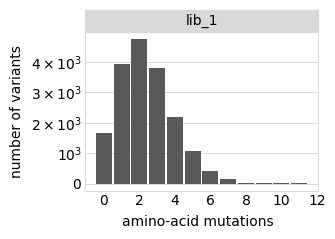

In [9]:
p = variants.plotNumMutsHistogram('aa',
                                  samples=None,
                                  widthscale=1.2,
                                  )
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

Average number of codon mutations of each type per variant:

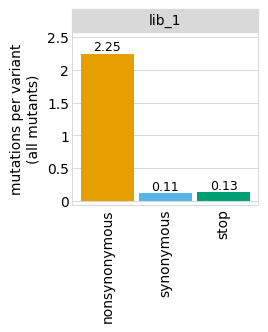

In [10]:
p = variants.plotNumCodonMutsByType(variant_type='all', samples=None)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

Examine how well amino-acid mutations are sampled in the library by looking at the
fraction
of mutations seen <= some number of times, making separate plots for single mutants and all mutants.
Most mutations are samples as single mutants, and all are sampled several times as multiple mutants:

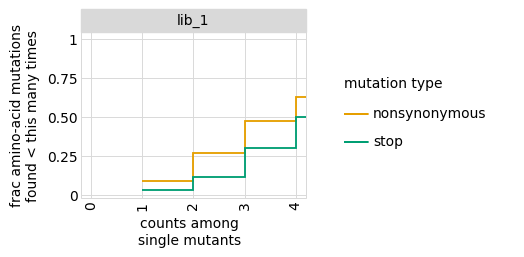

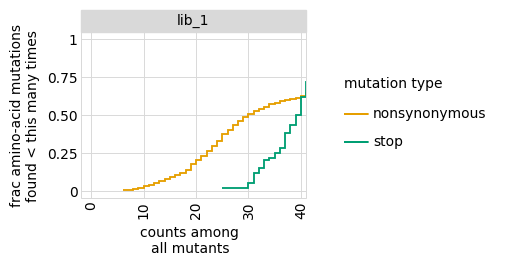

In [11]:
for variant_type in ['single', 'all']:
    p = variants.plotCumulMutCoverage(variant_type,
                                      mut_type='aa',
                                      samples=None)
    _ = p.draw()

## Simulate variant counts under two-latent phenotype global epistasis model
Now we simulate the counts of each variant after selection.
These simulations are done under a model of the phenotypic effects of mutations.

We define two latent-to-observed phenotype functions using an extension of the "global epistasis" concepts of [Otwinoski et
al](https://doi.org/10.1073/pnas.1804015115) and [Sailer and
Harms](https://doi.org/10.1534/genetics.116.195214).
In that concept, there is an "observed" phenotype which is a nonlinear function of an underlying "latent" phenotype that is affected additively by mutations.

Here we instead let the observed phenotype be the sum of **two** nonlinear functions each acting on a different latent phenotype.
Each nonlinear function is implemented via a [SigmoidPhenotypeSimulator](https://jbloomlab.github.io/dms_variants/dms_variants.simulate.html#dms_variants.simulate.SigmoidPhenotypeSimulator), and these are then combined in a [MultiLatentSigmoidPhenotypeSimulator](https://jbloomlab.github.io/dms_variants/dms_variants.simulate.html#dms_variants.simulate.MultiLatentSigmoidPhenotypeSimulator) that maps the two latent phenotypes to the observed phenotype.
The first latent phenotype is strongly affected by most mutations (you can imagine this is something like protein stability) and the other is strongly affected by only some mutations (you can imagine this is something like protein activity).

The counts for variants are then simulated according to their enrichments, which are the exponentials of the observed phenotype:

In [12]:
pheno1 = dms_variants.simulate.SigmoidPhenotypeSimulator(
                                geneseq,
                                seed=seed,
                                wt_latent=4,
                                stop_effect=-10,
                                norm_weights=[(0.4, -1.25, 1.25),
                                              (0.6, -5.5, 2.25),
                                              ]
                                )
pheno2 = dms_variants.simulate.SigmoidPhenotypeSimulator(
                                geneseq,
                                seed=seed,
                                wt_latent=3,
                                stop_effect=0,
                                norm_weights=[(0.7, 0, 0.1),
                                              (0.2, -8, 3),
                                              (0.1, -1, 2),
                                              ]
                                )

phenosimulator = dms_variants.simulate.MultiLatentSigmoidPhenotypeSimulator([pheno1, pheno2])

Plot the distribution of each latent phenotype, the, observed phenotype, and observed enrichment for all single amino-acid mutants, with a dashed vertical line indicating the wildtype:

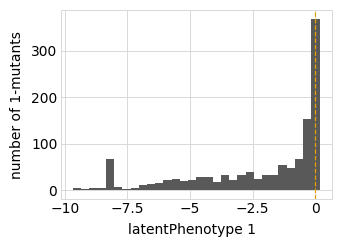

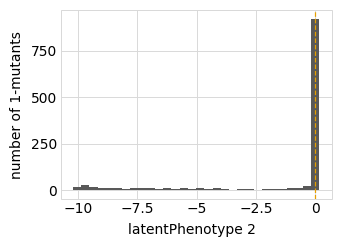

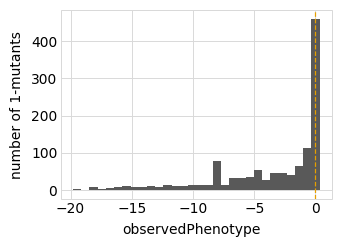

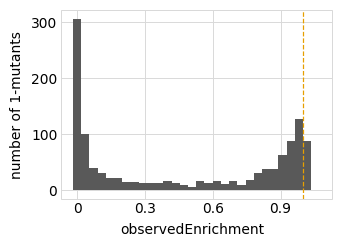

In [13]:
for value in ['latentPhenotype', 'observedPhenotype', 'observedEnrichment']:
    if value == 'latentPhenotype':
        for k in range(1, phenosimulator.n_latent_phenotypes + 1):
            p = phenosimulator.plotMutsHistogram(value, k=k)
            _ = p.draw()
    else:
        p = phenosimulator.plotMutsHistogram(value)
        _ = p.draw()

Use [simulateSampleCounts](https://jbloomlab.github.io/dms_variants/dms_variants.simulate.html#dms_variants.simulate.simulateSampleCounts) to simulate counts of variants when selection on each variant is proportional to
its observed enrichment:

In [14]:
counts = dms_variants.simulate.simulateSampleCounts(
        variants=variants,
        phenotype_func=phenosimulator.observedEnrichment,
        variant_error_rate=variant_error_rate,
        pre_sample={'total_count': variants_per_lib * avgdepth_per_variant,
                    'uniformity': lib_uniformity},
        pre_sample_name='pre-selection',
        post_samples={'post-selection': 
                          {'noise': noise,
                           'total_count': variants_per_lib * avgdepth_per_variant,
                           'bottleneck': variants_per_lib * bottleneck}
                      },
        seed=seed,
        )

Add the simulated counts for each library to the [CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable):

In [15]:
variants.add_sample_counts_df(counts)

Plot the number of counts for each variant. 
The horizontal dashed line shows the total number of variants. 
The plot shows that all variants are well-sampled in the pre-selection libraries, but that post-selection some variants are sampled more or less.
This is expected since selection will decrease and increase the frequency of variants:

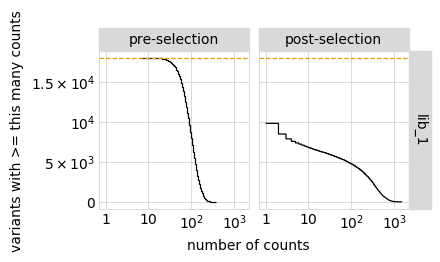

In [16]:
p = variants.plotCumulVariantCounts(libraries=variants.libraries,
                                    orientation='v')
_ = p.draw()

Distribution of the number of amino-acid mutations per variant.
As expected, mutations go down after selection:

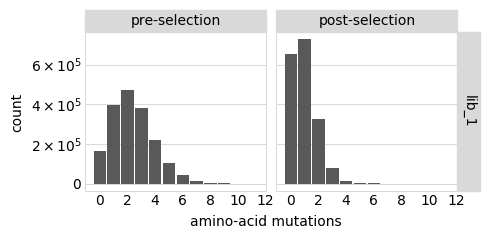

In [17]:
p = variants.plotNumMutsHistogram(mut_type='aa',
                                  libraries=variants.libraries,
                                  widthscale=1.2,
                                  orientation='v')
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

Average number of mutations per variant:

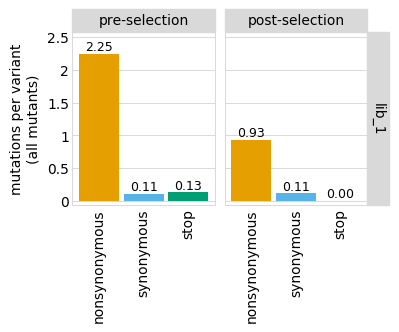

In [18]:
p = variants.plotNumCodonMutsByType(variant_type='all',
                                    libraries=variants.libraries,
                                    orientation='v')
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

## Functional scores for variants
Use
[CodonVariantTable.func_scores](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable.func_scores)
to calculates a functional score for each variant based on its change in
frequency from pre- to post-selection:

In [19]:
func_scores = variants.func_scores('pre-selection',
                                   libraries=variants.libraries)

Classify variants
by the “types” of mutations they
have using the
[CodonVariantTable.classifyVariants](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable.classifyVariants):

In [20]:
func_scores = dms_variants.codonvarianttable.CodonVariantTable.classifyVariants(func_scores)

Plot the distributions of scores, coloring by the variant class:

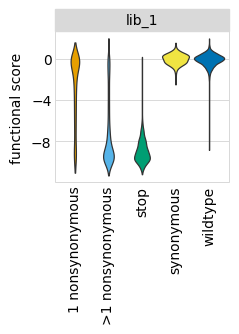

In [21]:
p = (
    ggplot(func_scores, aes('variant_class', 'func_score')) +
    geom_violin(aes(fill='variant_class')) +
    ylab('functional score') +
    xlab('') +
    facet_wrap('~ library', nrow=1) +
    theme(figure_size=(2.25 * len(variants.libraries), 2),
          axis_text_x=element_text(angle=90),
          panel_grid_major_x=element_blank(),  # no vertical grid lines
          ) +
    scale_fill_manual(values=CBPALETTE[1 :], guide=False)
    )
_ = p.draw()

# Everything below here is still in progress

In [22]:
# NBVAL_IGNORE_OUTPUT

for library, scores in func_scores.groupby('library', observed=True):
   
    bmap = dms_variants.binarymap.BinaryMap(scores)
    
    fits = dms_variants.globalepistasis.fit_models(bmap, 'Gaussian')
    
fits.round(1)

,description,n_latent_phenotypes,AIC,nparams,log_likelihood,model,fitting_time
0,global epistasis with 1 latent phenotypes,1,52530.4,1208,-25057.2,<dms_variants.globalepistasis.MonotonicSplineE...,10.6
1,global epistasis with 2 latent phenotypes,2,55431.2,2415,-25300.6,<dms_variants.globalepistasis.MonotonicSplineE...,12.7
2,no epistasis,1,81185.1,1202,-39390.6,<dms_variants.globalepistasis.NoEpistasisGauss...,0.3


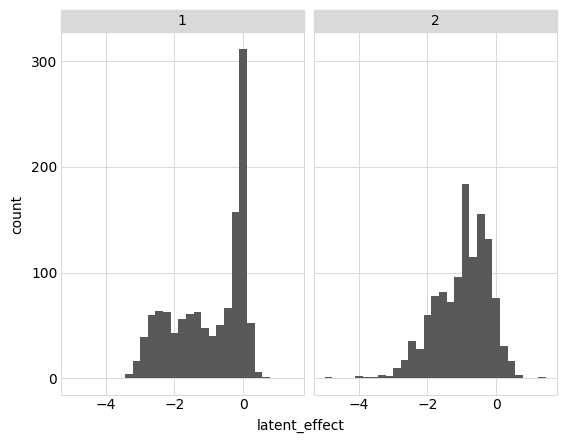

<ggplot: (8765399862883)>

In [23]:
m1 = fits['model'].values[0]
m2 = fits['model'].values[1]

(ggplot(m2.latent_effects_df, aes('latent_effect')) +
 geom_histogram() +
 facet_wrap('~ latent_phenotype_number')
 )

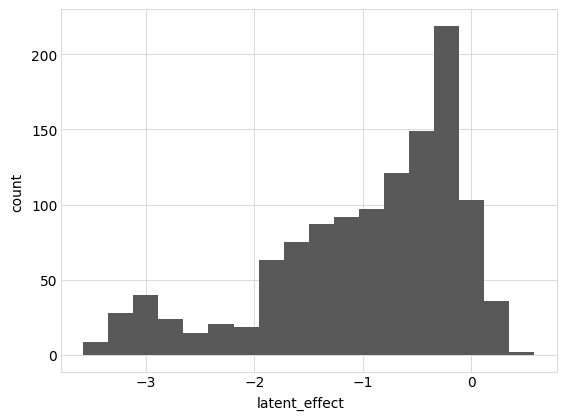

<ggplot: (8765402084216)>

In [24]:
(ggplot(m1.latent_effects_df, aes('latent_effect')) +
 geom_histogram())

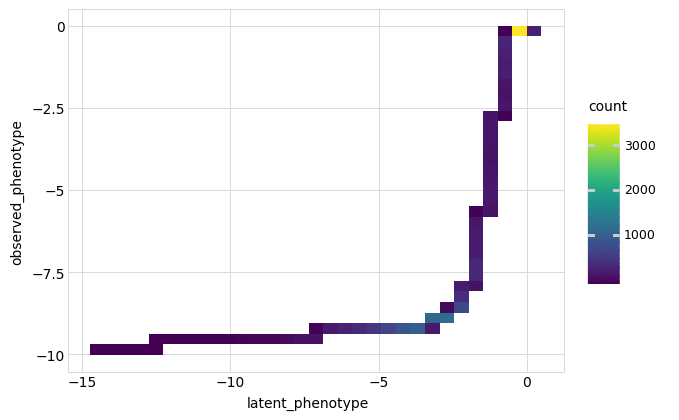

<ggplot: (-9223363271455319331)>

In [25]:
(ggplot(m1.phenotypes_df, aes('latent_phenotype', 'observed_phenotype')) + 
 geom_bin2d()
 )

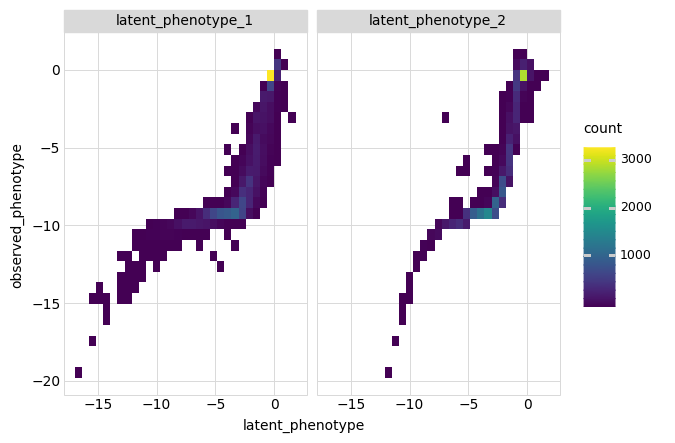

<ggplot: (-9223363271447667070)>

In [26]:
(ggplot(m2.phenotypes_df
        .melt(id_vars='observed_phenotype',
              value_vars=['latent_phenotype_1', 'latent_phenotype_2'],
              var_name='latent_phenotype_number',
              value_name='latent_phenotype',
             ),
        aes('latent_phenotype', 'observed_phenotype')) + 
 geom_bin2d() +
 facet_wrap('~ latent_phenotype_number')
 )

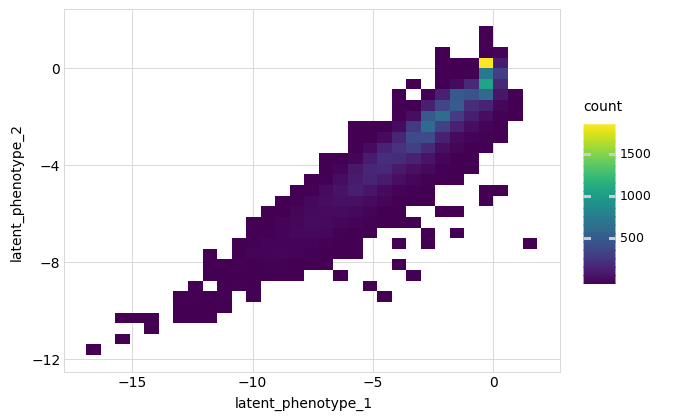

<ggplot: (8765407193671)>

In [27]:
ggplot(m2.phenotypes_df, aes('latent_phenotype_1', 'latent_phenotype_2')) + geom_bin2d()